# Predicting Dining Duration

So far we have a data dump from a few weeks of table service, and let's see if using the following features:

- Party size
- Day of week
- Hour of day
- Section Preferences

we can predict the dining duration.

We'll try applying linear regression and a couple of tree-based models (which have a better shot at fitting non-linear decision relationships) perform in predicting dining duration by training them on 70% of the data and testing them on the other 30% (perform cross validation).

That is, we fit the regression model using the known dining duration of 70% of the data, and then pretend we don't know the dining duration of the other 30% and use the model to predict it, and then compare the results.

## Loading in raw data and preprocessing

I have [a csv](table_parties.csv) that I exported by executing the following query:

```
SELECT
  merchant_parties.party_id,
  merchant_parties.party_size,
  merchant_parties.is_callahead,
  merchant_parties.section_preferences,
  MIN(table_status.created_ts) AS table_status_created,
  MAX(table_status.seated_ts) AS table_status_seated,
  MAX(table_status.done_ts) AS table_status_done
FROM
  table_status
INNER JOIN 
  merchant_parties ON table_status.party_id = merchant_parties.party_id
GROUP BY merchant_parties.party_id
ORDER BY merchant_parties.party_id
```

Let's load it into a pandas dataframe and massage this into the features mentioned above.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('table_parties.csv', parse_dates=['table_status_created', 'table_status_seated', 'table_status_done'])
df.replace('nan', np.nan, inplace=True)
df.head()

,party_id,party_size,is_callahead,section_preferences,table_status_created,table_status_seated,table_status_done
0,1112,2.0,False,{0},1470775644881,1470775644881,1470775655034
1,1113,NaN,False,{0},1470775692294,1470775692294,1470777247763
2,1114,9.0,False,{0},1470775717781,1470775717801,1470777237107
3,1119,1.0,False,{0},1470776137775,1470776137775,1470777242629
4,1120,3.0,False,NaN,1470788566003,1470788566003,NaN


In [2]:
df.isnull().sum()

party_id                   0
party_size              2636
is_callahead               0
section_preferences        3
table_status_created       0
table_status_seated     1070
table_status_done        275
dtype: int64

In [3]:
df.head(10)

,party_id,party_size,is_callahead,section_preferences,table_status_created,table_status_seated,table_status_done
0,1112,2.0,False,{0},1470775644881,1470775644881,1470775655034
1,1113,NaN,False,{0},1470775692294,1470775692294,1470777247763
2,1114,9.0,False,{0},1470775717781,1470775717801,1470777237107
3,1119,1.0,False,{0},1470776137775,1470776137775,1470777242629
4,1120,3.0,False,NaN,1470788566003,1470788566003,NaN
5,1123,3.0,False,{0},1470842383909,1470842398386,1470842470407
6,1126,50.0,False,{0},1470842444855,1470842444876,1470842468177
7,1128,6.0,False,{0},1470856716726,NaN,1470856968157
8,1129,12.0,False,{0},1470856775000,NaN,1470856971356
9,1132,4.0,False,{0},1470857739840,NaN,1470857773397


### Dealing with missing event timestamps

Let's ignore any party that is missing a 'table_status_done' cell:


In [4]:
df = df.dropna(subset=['table_status_done'])

and let's use `table_status_created` as a fallback for any entries where `table_status_seated` is missing.

In [5]:
def infer_seated(r):
    return r['table_status_created'] if pd.isnull(r['table_status_seated']) else r['table_status_seated']

df['seated'] = df.apply(infer_seated, axis=1)

### Computing dining duration, day of week and time of day attributes

In [6]:
int(df['table_status_created'][0])

1470775644881

In [7]:
import datetime

def parse_d(s):
    return datetime.datetime.fromtimestamp(int(s) / 1000.0)

def weekday(r):
    return parse_d(r['table_status_created']).weekday()

def hour_of_day(r):
    return parse_d(r['table_status_created']).hour

def duration_seconds(r):
    return (parse_d(r['table_status_done']) - parse_d(r['seated'])).total_seconds()

df['weekday'] = df.apply(weekday, axis=1)
df['hour_of_day'] = df.apply(hour_of_day, axis=1)
df['duration_seconds'] = df.apply(duration_seconds, axis=1)

In [8]:
df.head()

,party_id,party_size,is_callahead,section_preferences,table_status_created,table_status_seated,table_status_done,seated,weekday,hour_of_day,duration_seconds
0,1112,2.0,False,{0},1470775644881,1470775644881,1470775655034,1470775644881,1,16,10.153
1,1113,NaN,False,{0},1470775692294,1470775692294,1470777247763,1470775692294,1,16,1555.469
2,1114,9.0,False,{0},1470775717781,1470775717801,1470777237107,1470775717801,1,16,1519.306
3,1119,1.0,False,{0},1470776137775,1470776137775,1470777242629,1470776137775,1,16,1104.854
5,1123,3.0,False,{0},1470842383909,1470842398386,1470842470407,1470842398386,2,11,72.021


Some of the other attributes need preprocessing that is dependent on the training set, so we need to build functions to transform / preprocess as part of a pipeline.

### party size

Party size is straight forward, only trick is imputing missing values, as there are 2.6k of them. We'll replace missing values with the median.

### Day of week

Treating day of week as a quantitative variable doesn't make sense to me; it's not like dining on wed is somehow in between dining on tues and thursday w.r.t how long you'd expect my dining duration to be.

Instead, we'll one-hot encode the day of week into 7 categorical variables, the idea being if any particular days of the week are predictive of dining duration, we'll be able to extract that information. 

### section preferences

Most parties have section 0 preference but there are over a thousand that don't, so perhaps this will turn out to be predictive.

In [9]:
df['section_preferences'].value_counts()

{0}        4541
{3}         878
{2}         217
{9}          81
{13}         58
{0,3}        44
{0,13}       18
{0,0}        13
{0,9}        13
{0,2}         9
{12}          8
{13,0}        5
{0,12}        4
{3,0}         4
{2,1}         3
{2,0}         2
{0,8}         2
{9,9}         2
{2,3}         2
{2,2}         2
{0,0,0}       1
{3,3}         1
{1,2}         1
{1}           1
{12,11}       1
{12,13}       1
{8}           1
{11}          1
Name: section_preferences, dtype: int64

We'll encode each section as its own categorical variables, e.g 'section_0', 'section_3'. We'll develop a transforming operation to do this so we can plug it into a preprocessing pipeline.

#### Some utilitie pipeline transformers

First, let's define a couple of handy utility transformers and a base class for our custom section preference transformer.

In [10]:
from sklearn.base import TransformerMixin, BaseEstimator

class BaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        return self
    
class ColumnSelector(BaseTransformer):
    """Selects columns from Pandas Dataframe"""

    def __init__(self, columns, c_type=None):
        self.columns = columns
        self.c_type = c_type

    def transform(self, X, **transform_params):
        cs = X[self.columns]
        if self.c_type is None:
            return cs
        else:
            return cs.astype(self.c_type)

class DfTransformerAdapter(BaseTransformer):
    """Adapts a scikit-learn Transformer to return a pandas DataFrame"""

    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None, **fit_params):
        self.transformer.fit(X, y=y, **fit_params)
        return self

    def transform(self, X, **transform_params):
        raw_result = self.transformer.transform(X, **transform_params)
        return pd.DataFrame(raw_result, columns=X.columns, index=X.index)
    
    
class DfFeatureUnion(BaseTransformer):
    """A dataframe friendly implementation of `FeatureUnion`"""

    def __init__(self, transformers):
        self.transformers = transformers

    def fit(self, X, y=None, **fit_params):
        for l, t in self.transformers:
            t.fit(X, y=y, **fit_params)
        return self

    def transform(self, X, **transform_params):
        transform_results = [t.transform(X, **transform_params) for l, t in self.transformers]
        return pd.concat(transform_results, axis=1)

class DfOneHot(BaseTransformer):
    """
    Wraps helper method `get_dummies` making sure all columns get one-hot encoded.
    """
    def __init__(self):
        self.dummy_columns = []

    def fit(self, X, y=None, **fit_params):
        self.dummy_columns = pd.get_dummies(
            X,
            prefix=[c for c in X.columns],
            columns=X.columns).columns
        return self

    def transform(self, X, **transform_params):
        return pd.get_dummies(
            X,
            prefix=[c for c in X.columns],
            columns=X.columns).reindex(columns=self.dummy_columns, fill_value=0)


#### Our custom transformer for section preference

Now onto our custom transformer. Note: this is general enough to handle any number of columns containing this information, which is overkill, but follows the general pattern of developing transformers that I've grown accustom to, which is that each transformer handles an entire dataframe that is assuemd to only include columns of interest.

The preprocessing pipeline is then crafted to select the appropriate columns to and pipe them into the appropriate transformations, and then unions them all back together. For more on this, see [this blog post](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html).

In [11]:
class EncodeSectionPrefs(BaseTransformer):
    def __init__(self):
        self.column_sections = {}

    def fit(self, X, y=None, **fit_params):
        self.column_sections = {col: unique_sections(X[col]) for col in X.columns}
        return self

    def transform(self, X, **transform_params):        
        return pd.concat(
            [encode_column(X[col], self.column_sections[col]) for col in X.columns],
            axis=1
        )

def flatten1(l):
    return [item for sublist in l for item in sublist] 

def parse_sections(s):
    """
    e.g '{0, 2}' => [0, 2]
    """
    if isinstance(s, str) and len(s) > 0:
        return map(int, s[1:-1].split(','))
    else:
        return []

def unique_sections(series):
    """
    e.g ['{0, 2}', '{1}', '{1, 3}'] => [0, 1, 2, 3]
    """
    return sorted(set(flatten1([parse_sections(sections) for sections in series])))

def encode_column(col, all_sections):
    def flatten_cell(cell):
        cell_sections = parse_sections(cell)
        return pd.Series([1 if s in cell_sections else 0 for s in all_sections])
    
    df = col.apply(flatten_cell)
    df.columns = ["section_{}".format(section) for section in all_sections]
    return df    
    

As a quick demo, here is the transformer applied to just the seciton column:

In [12]:
transformer = EncodeSectionPrefs()
transformer.fit_transform(df[['section_preferences']]).head()


,section_0,section_1,section_2,section_3,section_8,section_9,section_11,section_12,section_13
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0


### Putting it all together

Without further ado, we can put together a transforming pipeline that is ready to perform these data dependent transformations:

- impute missing party_size with the median
- encode the sections into new columns

In [13]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

df['weekday'] = df.apply(weekday, axis=1)
df['hour_of_day'] = df.apply(hour_of_day, axis=1)
df['duration_seconds'] = df.apply(duration_seconds, axis=1)

preprocessor = Pipeline([
    ('features', DfFeatureUnion([
        ('quantitative', Pipeline([
            ('select-quantitative', ColumnSelector(['party_size', 'hour_of_day'], c_type='float')),
            ('impute-missing', DfTransformerAdapter(Imputer(strategy='median')))
        ])),
        ('encode-weekday', Pipeline([
            ('select-weekeday', ColumnSelector(['weekday'])),
            ('onehot-encode', DfOneHot())
        ])),
        ('encode-section-prefs', Pipeline([
            ('select-section-prefs', ColumnSelector(['section_preferences'])),
            ('encode', EncodeSectionPrefs())
        ]))
    ]))
])

And now we can finally see our cleaned up dataset after applying our preprocessing:

In [14]:
df_transformed = preprocessor.fit_transform(df)
df_transformed.head()

,party_size,hour_of_day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,section_0,section_1,section_2,section_3,section_8,section_9,section_11,section_12,section_13
0,2.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0
1,3.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0
2,9.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0
3,1.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0
5,3.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0


## Examining the quantitative variables

Let's look at a scatter matrix and a corrleation matrix to see if there are any insights to be had.

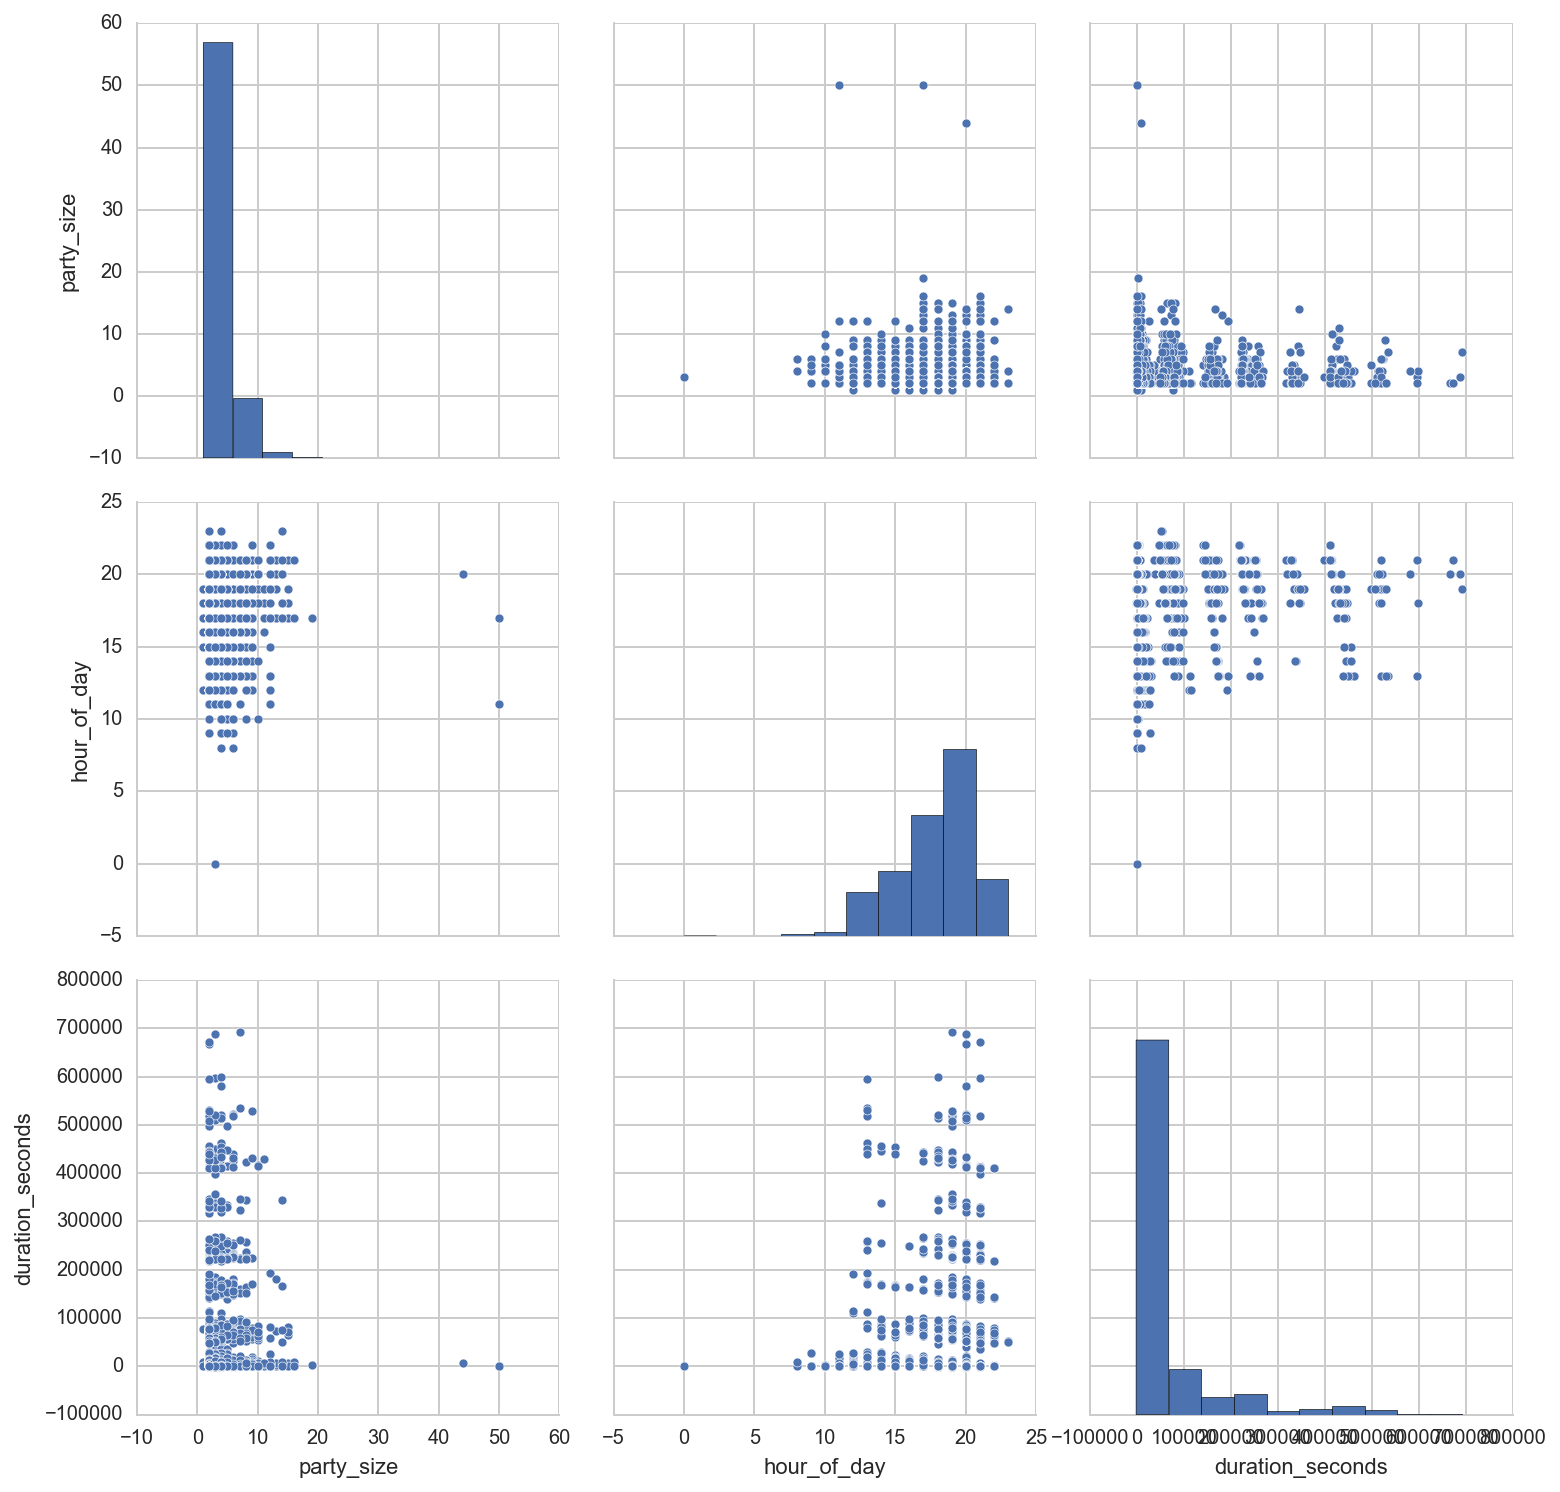

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', context='notebook')

sns.pairplot(df[['party_size', 'hour_of_day', 'duration_seconds']].dropna(), size=3.5)

plt.show()

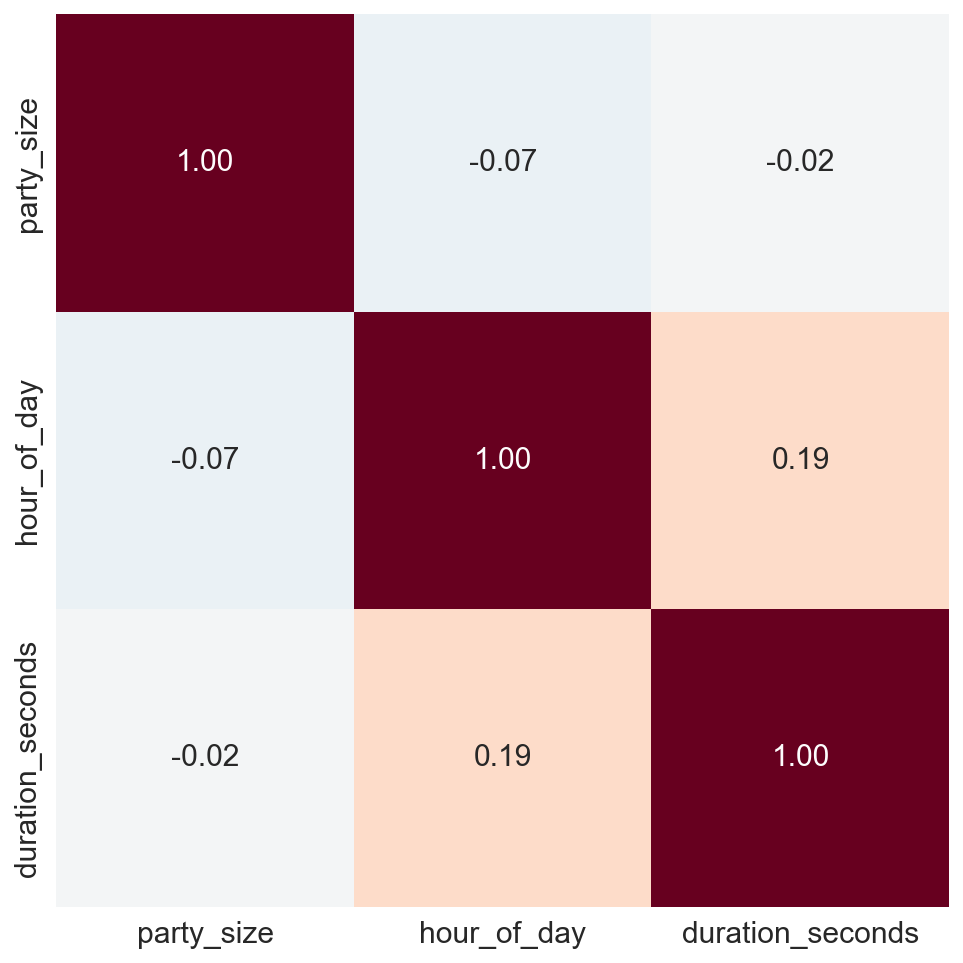

In [16]:
cm = np.corrcoef(df[['party_size', 'hour_of_day', 'duration_seconds']].dropna().values.T)
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(8, 8))

hm = sns.heatmap(cm,
                 ax=ax,
                 cbar=False,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=['party_size', 'hour_of_day', 'duration_seconds'],
                 xticklabels=['party_size', 'hour_of_day', 'duration_seconds'])

plt.show()

Unfortunately it doesn't look like party_size will be of much help, though hour_of_day may give some signal.

## Trying some models

Let's test out some models and see how well they do.

In [17]:
from sklearn.cross_validation import train_test_split

feature_cols = ['party_size', 'section_preferences', 'weekday', 'hour_of_day', 'duration_seconds']

def extract_X_y(df):
    return df[feature_cols], df['duration_seconds']

X, y = extract_X_y(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [18]:
(X.shape, X_train.shape, X_test.shape)

((5916, 5), (3549, 5), (2367, 5))

In [19]:
from sklearn import linear_model

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [20]:
models = [
    ('LR', Pipeline([
        ('preprocess', preprocessor),
        ('model', linear_model.LinearRegression())
    ])),
    ('Decision Tree', Pipeline([
        ('preprocess', preprocessor),
        ('model', DecisionTreeRegressor(max_depth=8))
    ])),
    ('Random Forest', Pipeline([
        ('preprocess', preprocessor),
        ('model', RandomForestRegressor(n_estimators=1000,
                                        criterion='mse',
                                        random_state=1,
                                        n_jobs=-1))
    ])),
]


In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [22]:
scores = {}
for label, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)    
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    scores[label] = (r2_train, r2_test, mse_train, mse_test)
    print('{} R2 scores (train/test): {:.2f}/{:.2f}. MSE (train/test): {:.2f}/{:.2f}'.format(
            label, 
            r2_train, r2_test,
            mse_train, mse_test))

LR R2 scores (train/test): 0.03/0.03. MSE (train/test): 7332737017.98/6295676231.63
Decision Tree R2 scores (train/test): 0.20/-0.04. MSE (train/test): 6059139673.72/6732653372.07
Random Forest R2 scores (train/test): 0.24/-0.02. MSE (train/test): 5698292338.97/6640206111.69


## Conclusions

It looks like there isn't really any signal w.r.t dining duration in the meager set of features we first looked at:

- Party size
- Day of week
- Hour of day
- Section Preferences

We weren't even able to (over)fit the training data with non-linear models.

My best guess is we'll need more features about the users before this bears any fruit.
